In [8]:
#import necessary libraries and Modules
import ImageManipFuncs as IMF
import PlottingFuncs as PF
import ImageAnalysis as IA
import myGUI 
import photoutils
import importlib
import cv2
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import os
import ipywidgets as widgets
from IPython.display import display
import math
from PIL import Image, ImageDraw, ImageTk, ImageOps
import tkinter as tk
from tkinter import ttk
from astropy.io import fits
from skimage.morphology import skeletonize
from skimage import io
import csv
import Metric

In [9]:
importlib.reload(IMF)
importlib.reload(PF)
importlib.reload(IA)

<module 'ImageAnalysis' from 'c:\\Users\\HP\\Documents\\JHU_Academics\\Research\\PHANGS\\PHANGSDustFill\\ImageAnalysis.py'>

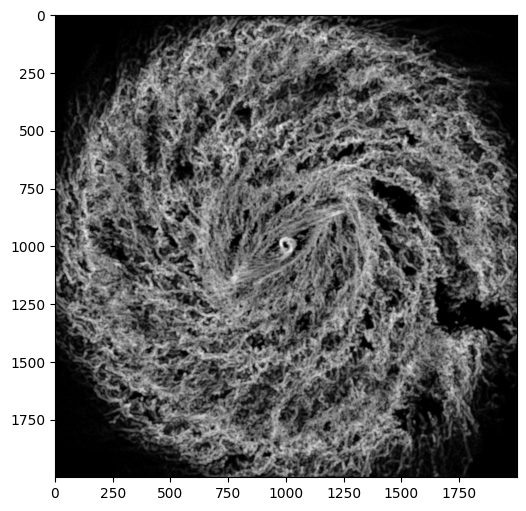

In [10]:
# Specify the path to your FITS file
#fits_file = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\JWST_F770W_filamentenhanced_multiscale_examples (1)\Users\dthilker\python\Constrained-Diffusion-Decomposition-main\ngc4321_770_CDDss0064pc_arcsinh0p1_sato.fits'
fits_file = r"C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\galaxysim_SigmaHI_scaledecomposed_intensitytransformed\galaxysim_SigmaHI_CDDss0064pc_arcsinh0p1.fits"
# Load the FITS file data
hdul = fits.open(fits_file)
image_data = np.array(hdul[0].data)  # Assuming the image data is in the primary HDU
header = hdul[0].header
#header = hdul[0].header  # Get the header of the primary HDU

# Set the desired figure size (width, height) in inches
fig_size = (6, 6)  # Adjust this to your desired size

# Create a figure with the specified size
plt.figure(figsize=fig_size)
plt.imshow(np.flipud(image_data), cmap = "gray")
plt.show()


In [11]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from astropy.io import fits
from math import tan, radians


pixel_scale_deg_x = header.get('CDELT1', None)  # Pixel scale in degrees (x direction)
pixel_scale_deg_y = header.get('CDELT2', None)  # Pixel scale in degrees (y direction)

# Check if pixel scale values are available
if pixel_scale_deg_x is None or pixel_scale_deg_y is None:
    print("Pixel scale information (CDELT1 and CDELT2) not found in FITS header")
    pixel_size_pc = 24
else: 
    # Convert pixel scale from degrees to arcseconds
    pixel_scale_arcsec_x = pixel_scale_deg_x * 3600
    pixel_scale_arcsec_y = pixel_scale_deg_y * 3600

    # Extract distance to the object from the header (assuming it's stored as a keyword)
    distance_pc = header.get('DISTANCE', None)  # Default to 1000 parsecs if not found

    if distance_pc is None:
        # Distance not found in header, provide a default value or handle the error
        print("Distance not found in FITS header. Using default value of 50,000,000 parsecs.")
        distance_pc = 50000000  # Default to 1000 parsecs if not found

    # Use an average pixel scale if X and Y scales are significantly different
    if not np.isclose(pixel_scale_arcsec_x, pixel_scale_arcsec_y):
        print(f'Warning: X and Y pixel scales are different. Using average scale.')
        pixel_scale_arcsec = (pixel_scale_arcsec_x + pixel_scale_arcsec_y) / 2
    else:
        pixel_scale_arcsec = pixel_scale_arcsec_x  # or pixel_scale_arcsec_y; they are close

    # Convert pixel scale from arcseconds to radians
    pixel_scale_rad = np.deg2rad(pixel_scale_arcsec / 3600)  # arcseconds to radians

    # Compute the physical size of one pixel in parsecs
    pixel_size_pc = distance_pc * np.tan(pixel_scale_rad)

    print(f'Pixel scale (arcseconds/pixel): {pixel_scale_arcsec}')
    print(f'Pixel size in parsecs: {pixel_size_pc}')


Pixel scale information (CDELT1 and CDELT2) not found in FITS header


In [12]:
import os
#parameters to adjust
aspect_ratio_source = 2
aspect_ratio_deblend = 1
threshold_factor = .35
area_factor = .5
image_name = os.path.basename(fits_file)
print(f'Image is: { image_name}')

if '16pc' in fits_file: 
    source_pixel_min = (aspect_ratio_source*16*16)/pixel_size_pc
    deblend_pixel_min = (aspect_ratio_deblend*16*16)/pixel_size_pc
    area_to_retain = 16*16*area_factor/pixel_size_pc
    print('image is 16 parcec scale')

elif '32pc' in fits_file: 
    source_pixel_min = (aspect_ratio_source*32*32)/pixel_size_pc
    deblend_pixel_min = (aspect_ratio_deblend*32*32)/pixel_size_pc
    area_to_retain = 32*32*area_factor/pixel_size_pc
    print('image is 32 parcec scale')

elif '64pc' in fits_file:
    source_pixel_min = (aspect_ratio_source*64*64)/pixel_size_pc
    deblend_pixel_min = (aspect_ratio_deblend*64*64)/pixel_size_pc
    area_to_retain = 64*64*area_factor/pixel_size_pc
    print('image is 64 parcec scale')
elif '128pc' in fits_file:
    source_pixel_min = (aspect_ratio_source*128*128)/pixel_size_pc
    deblend_pixel_min = (aspect_ratio_deblend*128*128)/pixel_size_pc
    area_to_retain = 128*128*area_factor/pixel_size_pc
    print('image is 128 parcec scale')

elif '256pc' in fits_file:
    source_pixel_min = (aspect_ratio_source*256*256)/pixel_size_pc
    deblend_pixel_min = (aspect_ratio_deblend*256*256)/pixel_size_pc
    area_to_retain = 256*256*area_factor/pixel_size_pc
    print('image is 256 parcec scale')

else:
    print('invalid fits file')

print(f'num pixels for source detection: {source_pixel_min}')
print(f'num pixels for deblending: {deblend_pixel_min}')
print(f'min pixel area to retain: {area_to_retain}')

Image is: galaxysim_SigmaHI_CDDss0064pc_arcsinh0p1.fits
image is 64 parcec scale
num pixels for source detection: 341.3333333333333
num pixels for deblending: 170.66666666666666
min pixel area to retain: 85.33333333333333


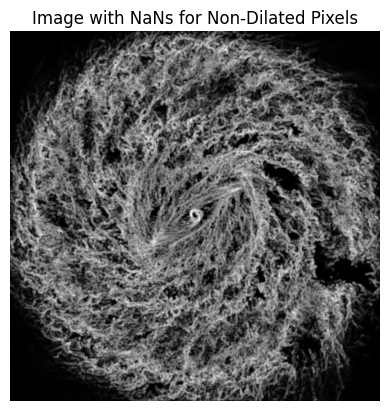

In [13]:
import copy

mask_copy = copy.deepcopy(image_data)
mask_copy[mask_copy != 0] = 255
mask_copy = mask_copy.astype(np.uint8)

# Define the kernel size for dilation
kernel_size = 3
kernel = np.ones((kernel_size, kernel_size), np.uint8)

# Perform dilation
dilated_image = cv2.dilate(mask_copy, kernel, iterations=30)

# Convert dilated_image to float32 to handle NaN values
image_data = image_data.astype(np.float32)

# Set non-dilated pixels to NaN
image_data[dilated_image == 0] = np.nan

# Create a colormap with NaNs as a specific color
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('nan_color', [(0, 0, 0), (1, 1, 1)], N=256)
cmap.set_bad('gray')  # Set NaNs to a color (e.g., gray)

# Step 1: Create a mask for NaN values
mask = np.isnan(image_data)

# Create a binary mask where NaNs are 0 and non-NaNs are 255
binary_mask = np.zeros_like(image_data, dtype=np.uint8)
binary_mask[mask] = 255
binary_mask[~mask] = 0

# Step 2: Define the kernel size for dilation
kernel_size = 9
kernel = np.ones((kernel_size, kernel_size), np.uint8)

# Perform dilation on the binary mask
dilated_mask = cv2.dilate(binary_mask, kernel, iterations=14)

# Step 3: Create a copy of the original image
dilated_image = copy.deepcopy(image_data)

# Replace the original NaN areas with the dilated mask
# Here, 0s in the dilated mask correspond to NaNs in the original image
dilated_image[dilated_mask==255] = np.nan

# Create a colormap with NaNs as a specific color
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('nan_color', [(0, 0, 0), (1, 1, 1)], N=256)
cmap.set_bad('gray')  # Set NaNs to a color (e.g., gray)

# Display the modified image_data with NaNs
plt.imshow(np.flipud(dilated_image), cmap=cmap)
plt.axis('off')  # Hide axis
plt.title('Image with NaNs for Non-Dilated Pixels')
plt.show()


DETECTING
deblending


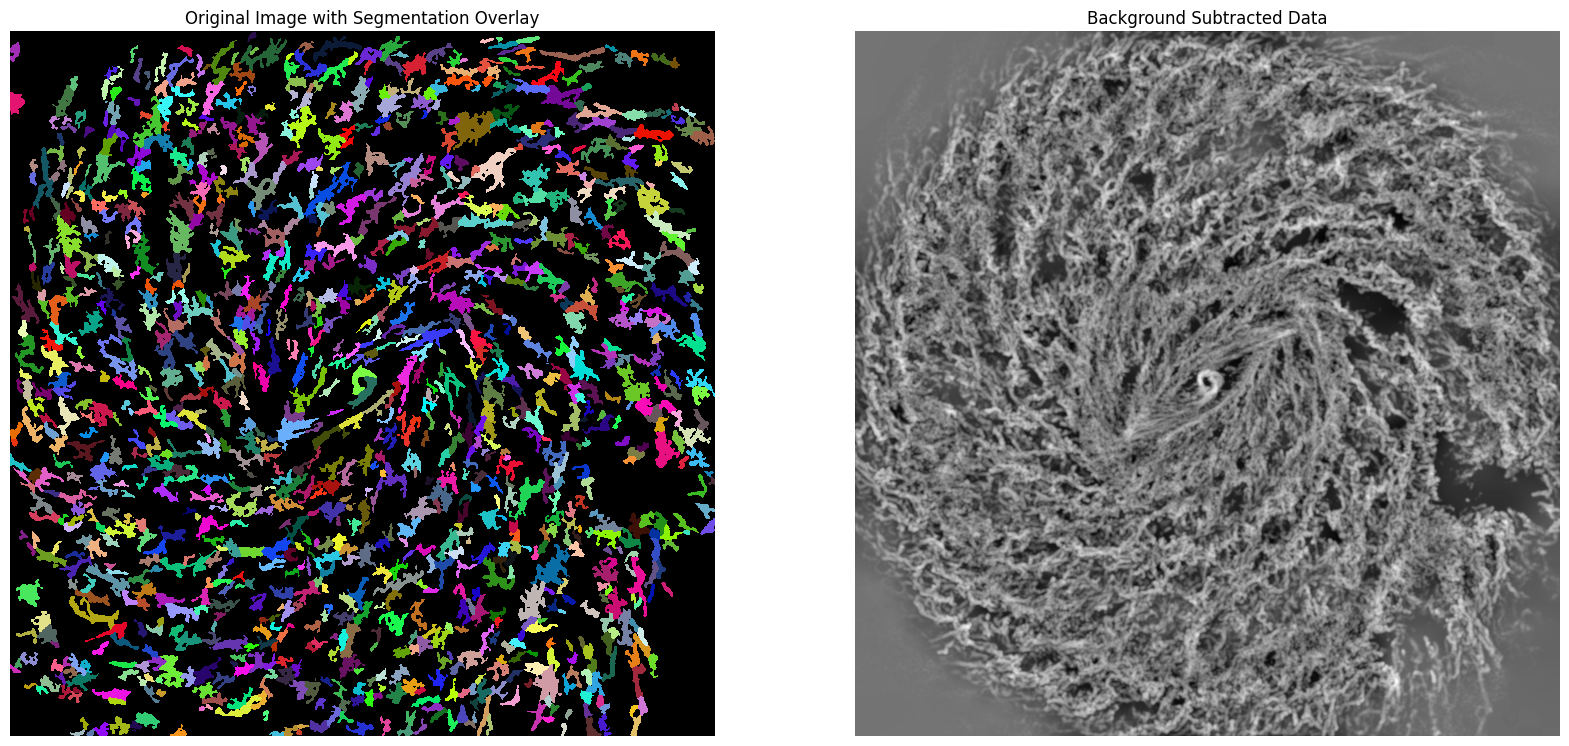

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.segmentation import make_2dgaussian_kernel, detect_sources, deblend_sources
from photutils.background import Background2D, MedianBackground
from astropy.convolution import convolve
from matplotlib.colors import ListedColormap

path = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\SmallFilamentsGone.png'
data = dilated_image
data = data.astype(np.float64)

# Background subtraction
bkg_estimator = MedianBackground()
bkg = Background2D(data, (50, 50), filter_size=(3, 3), bkg_estimator=bkg_estimator)
data -= bkg.background

# Thresholding and convolution
threshold = threshold_factor*bkg.background_rms
kernel = make_2dgaussian_kernel(3.0, size=11)
convolved_data = convolve(data, kernel)

# Source detection and deblending
print('DETECTING')
segment_map = detect_sources(convolved_data, threshold, npixels=int(source_pixel_min))
print("deblending")
segment_map = deblend_sources(convolved_data, segment_map, npixels=int(deblend_pixel_min), nlevels=100, contrast=0.001, progress_bar=False)

# Colormap and normalization
num_segments = segment_map.data.max()
colors = np.random.rand(num_segments + 1, 3)
colors[0] = [0, 0, 0]  # Background as black
cmap = ListedColormap(colors)

norm = ImageNormalize(stretch=SqrtStretch())
segmentation_image_normalized = norm(segment_map.data)

#segmentation_image_flipped = np.flipud(segmentation_image_normalized)
#data_flipped = np.flipud(data)

# Plot and save
fig, axes = plt.subplots(1, 2, figsize=(20, 12.5))

axes[0].imshow(segmentation_image_normalized, origin='lower', cmap=cmap, alpha=1, interpolation='nearest')
axes[0].set_title('Original Image with Segmentation Overlay')
axes[0].axis('off')

axes[1].imshow(data, cmap='gray', origin='lower')
axes[1].set_title('Background Subtracted Data')
axes[1].axis('off')

# Save the subplot image
subplot_image_path = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\overlaid_subplot_image.png'
plt.imsave(subplot_image_path, np.flipud(segmentation_image_normalized), cmap=cmap)

# Save the binary segmented image
binary_segment_image = (segment_map.data > 0).astype(np.uint8) * 255
image_path_segments = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\segments.png'
plt.imsave(image_path_segments, np.flipud(binary_segment_image), cmap='gray')

# Normalize and save the zoomed image
#data_flipped = data_flipped.astype(np.uint8) * 255
data= np.nan_to_num(data, nan=0)
image_path_zoomed = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\zoomed_image.png'
plt.imsave(image_path_zoomed, np.flipud(data), cmap='gray')

# Show the plot
plt.show()


(2000, 2000, 4)
(2000, 2000)


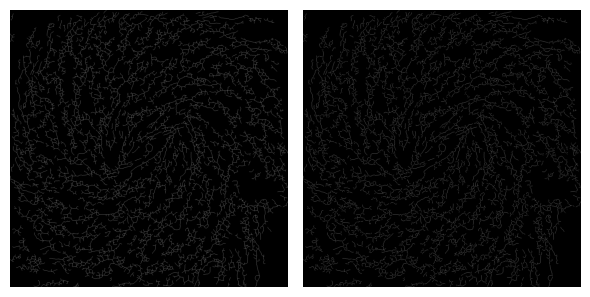

(2000, 2000)


In [56]:
importlib.reload(IA)
importlib.reload(IMF)
def neighbours(x, y, image):
    """Return 8-neighbours of image point P1(x,y), in a clockwise order"""
    img = image
    x_1, y_1, x1, y1 = x - 1, y - 1, x + 1, y + 1
    return [img[x_1][y], img[x_1][y1], img[x][y1], img[x1][y1], img[x1][y], img[x1][y_1], img[x][y_1], img[x_1][y_1]]

def getSkeletonIntersection(skeleton):
    """ Given a skeletonised image, it will give the coordinates of the intersections of the skeleton.
    
    Keyword arguments:
    skeleton -- the skeletonised image to detect the intersections of
    
    Returns: 
    List of 2-tuples (x,y) containing the intersection coordinates
    """
    validIntersection = [[0,1,0,1,0,0,1,0],[0,0,1,0,1,0,0,1],[1,0,0,1,0,1,0,0],
                         [0,1,0,0,1,0,1,0],[0,0,1,0,0,1,0,1],[1,0,0,1,0,0,1,0],
                         [0,1,0,0,1,0,0,1],[1,0,1,0,0,1,0,0],[0,1,0,0,0,1,0,1],
                         [0,1,0,1,0,0,0,1],[0,1,0,1,0,1,0,0],[0,0,0,1,0,1,0,1],
                         [1,0,1,0,0,0,1,0],[1,0,1,0,1,0,0,0],[0,0,1,0,1,0,1,0],
                         [1,0,0,0,1,0,1,0],[1,0,0,1,1,1,0,0],[0,0,1,0,0,1,1,1],
                         [1,1,0,0,1,0,0,1],[0,1,1,1,0,0,1,0],[1,0,1,1,0,0,1,0],
                         [1,0,1,0,0,1,1,0],[1,0,1,1,0,1,1,0],[0,1,1,0,1,0,1,1],
                         [1,1,0,1,1,0,1,0],[1,1,0,0,1,0,1,0],[0,1,1,0,1,0,1,0],
                         [0,0,1,0,1,0,1,1],[1,0,0,1,1,0,1,0],[1,0,1,0,1,1,0,1],
                         [1,0,1,0,1,1,0,0],[1,0,1,0,1,0,0,1],[0,1,0,0,1,0,1,1],
                         [0,1,1,0,1,0,0,1],[1,1,0,1,0,0,1,0],[0,1,0,1,1,0,1,0],
                         [0,0,1,0,1,1,0,1],[1,0,1,0,0,1,0,1],[1,0,0,1,0,1,1,0],
                         [1,0,1,1,0,1,0,0]]
    image = skeleton.copy() / 255
    intersections = []
    for x in range(1, len(image) - 1):
        for y in range(1, len(image[x]) - 1):
            # If we have a white pixel
            if image[x][y] == 1:
                neighbors = neighbours(x, y, image)
                if neighbors in validIntersection:
                    intersections.append((y, x))
    
    # Filter intersections to make sure we don't count them twice or ones that are very close together
    filtered_intersections = []
    for point1 in intersections:
        add_point = True
        for point2 in filtered_intersections:
            if ((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2) < 10**2:
                add_point = False
                break
        if add_point:
            filtered_intersections.append(point1)
    
    return filtered_intersections

# File paths
skeleton_image_path = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\skeletonized_image.png'
output_image_path = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\intersections_flagged.png'

# Read the grayscale image
segments = binary_segment_image

# Convert image to binary (skeletonize expects a binary image)
binary_image = segments > 0

# Apply skeletonization
skeleton_image = skeletonize(binary_image)

# Find the intersections
intersections = getSkeletonIntersection(np.array(255*skeleton_image))

# Draw intersections on the original image
#draw_intersections(skeleton_image_path, intersections, output_image_path)

intersects_removed = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\ThresholdedImageNoIntersects.png'

no_intersects = IA.remove_junctions(intersections, skeleton_image, intersects_removed, dot_size = 2)

print(np.shape(no_intersects))

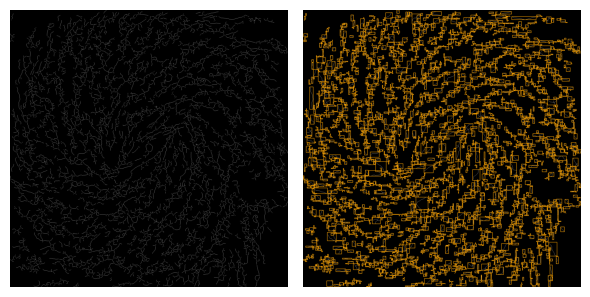

In [47]:
importlib.reload(IA)
labels, stats, num_labels = IA.identify_connected_components(np.array(no_intersects))

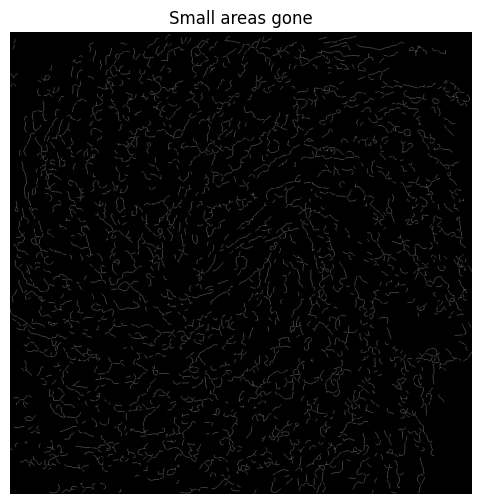

True

In [49]:
importlib.reload(IA)
small_areas = IA.sort_label_id(num_labels, stats, int(area_to_retain))
img = np.array(no_intersects)

for label_id in small_areas:
    # Extract the bounding box coordinates
    left = stats[label_id, cv2.CC_STAT_LEFT]
    top = stats[label_id, cv2.CC_STAT_TOP]
    width = stats[label_id, cv2.CC_STAT_WIDTH]
    height = stats[label_id, cv2.CC_STAT_HEIGHT]
    for x in range(width):
        for y in range(height):
            img[top:top+height, left:left+width] = 0


# Set the desired figure size (width, height) in inches
fig_size = (6, 6)  # Adjust this to your desired size

# Create a figure with the specified size
plt.figure(figsize=fig_size)

# Display the thresholded image (optional)
plt.imshow(np.flipud(img), cmap='gray')
plt.axis('off')  # Turn off axes
plt.title('Small areas gone')
plt.show()


cv2.imwrite(r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\SmallFilamentsGone.png', img)
    

on filament 1
on filament 2
on filament 3
on filament 4
on filament 5
on filament 6
on filament 7
on filament 8
on filament 9
on filament 10
on filament 11
on filament 12
on filament 13
on filament 14
on filament 15
on filament 16
on filament 17
on filament 18
on filament 19
on filament 20
on filament 21
on filament 22
on filament 23
on filament 24
on filament 25
on filament 26
on filament 27
on filament 28
on filament 29
on filament 30
on filament 31
on filament 32
on filament 33
on filament 34
on filament 35
on filament 36
on filament 37
on filament 38
on filament 39
on filament 40
on filament 41
on filament 42
on filament 43
on filament 44
on filament 45
on filament 46
on filament 47
on filament 48
on filament 49
on filament 50
on filament 51
on filament 52
on filament 53
on filament 54
on filament 55
on filament 56
on filament 57
on filament 58
on filament 59
on filament 60
on filament 61
on filament 62
on filament 63
on filament 64
on filament 65
on filament 66
on filament 67
on f

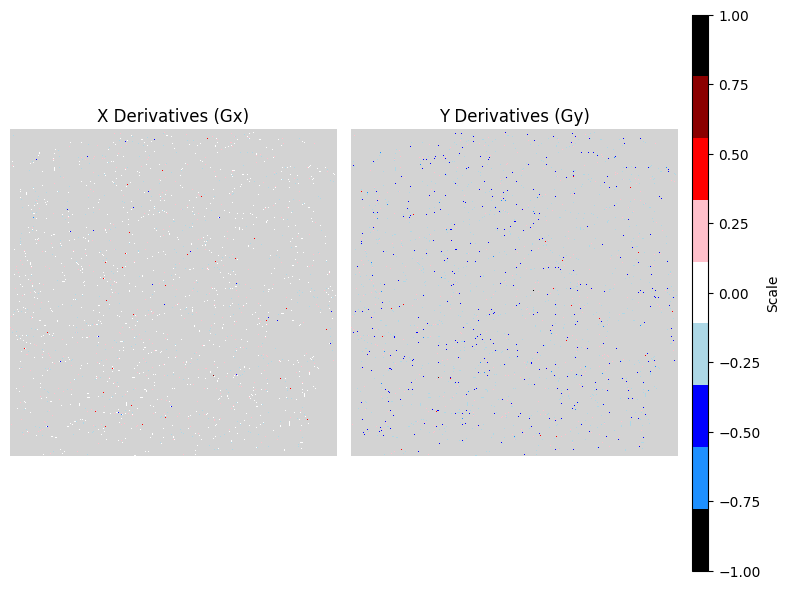

In [50]:
import cv2
import numpy as np
from skimage.morphology import skeletonize
import importlib

# Assuming segment_map is already defined from previous segmentation process

processed_img = img

# Number of segments
num_segments = segment_map.data.max()

# Initialize Gx and Gy matrices to store results for the entire image
Gx_total = np.zeros_like(binary_segment_image, dtype=np.float64)
Gy_total = np.zeros_like(binary_segment_image, dtype=np.float64)
skel = np.zeros_like(binary_segment_image, dtype=np.float64)

# Loop through each segment to create and display individual masks
for i in range(1, num_segments + 1):
    processed_img_copy = copy.deepcopy(processed_img)
    print(f"on filament {i}")
    # Create a mask where only the current segment is white
    mask = np.zeros_like(segment_map.data, dtype=np.uint8)
    mask[segment_map.data == i] = 255
    processed_img_copy[(mask == 255) & (processed_img == 255)] = 255  # Keep white where mask and processed_img are both white
    processed_img_copy[(mask != 255)] = 0    # Set all other pixels to black
    
        
    # plt.imshow(processed_img_copy, cmap = "gray")
    # plt.show()

    # Apply Sobel filter to the masked component
    sobelx = cv2.Sobel(processed_img_copy, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(processed_img_copy, cv2.CV_64F, 0, 1, ksize=3)
    
    Gx_total += sobelx
    Gy_total += sobely

PF.plot_sobel_derivatives(processed_img, Gx_total, Gy_total)


c:\Users\HP\Documents\JHU_Academics\Research\PHANGS\PHANGSDustFill\PlottingFuncs.py:99: RuntimeWarning: divide by zero encountered in divide
  angle_map = -1 * np.degrees(np.arctan(Gy / Gx))
c:\Users\HP\Documents\JHU_Academics\Research\PHANGS\PHANGSDustFill\PlottingFuncs.py:99: RuntimeWarning: invalid value encountered in divide
  angle_map = -1 * np.degrees(np.arctan(Gy / Gx))
c:\Users\HP\Documents\JHU_Academics\Research\PHANGS\PHANGSDustFill\PlottingFuncs.py:84: RuntimeWarning: invalid value encountered in scalar divide
  return np.degrees(np.arctan(sin_sum/cos_sum))


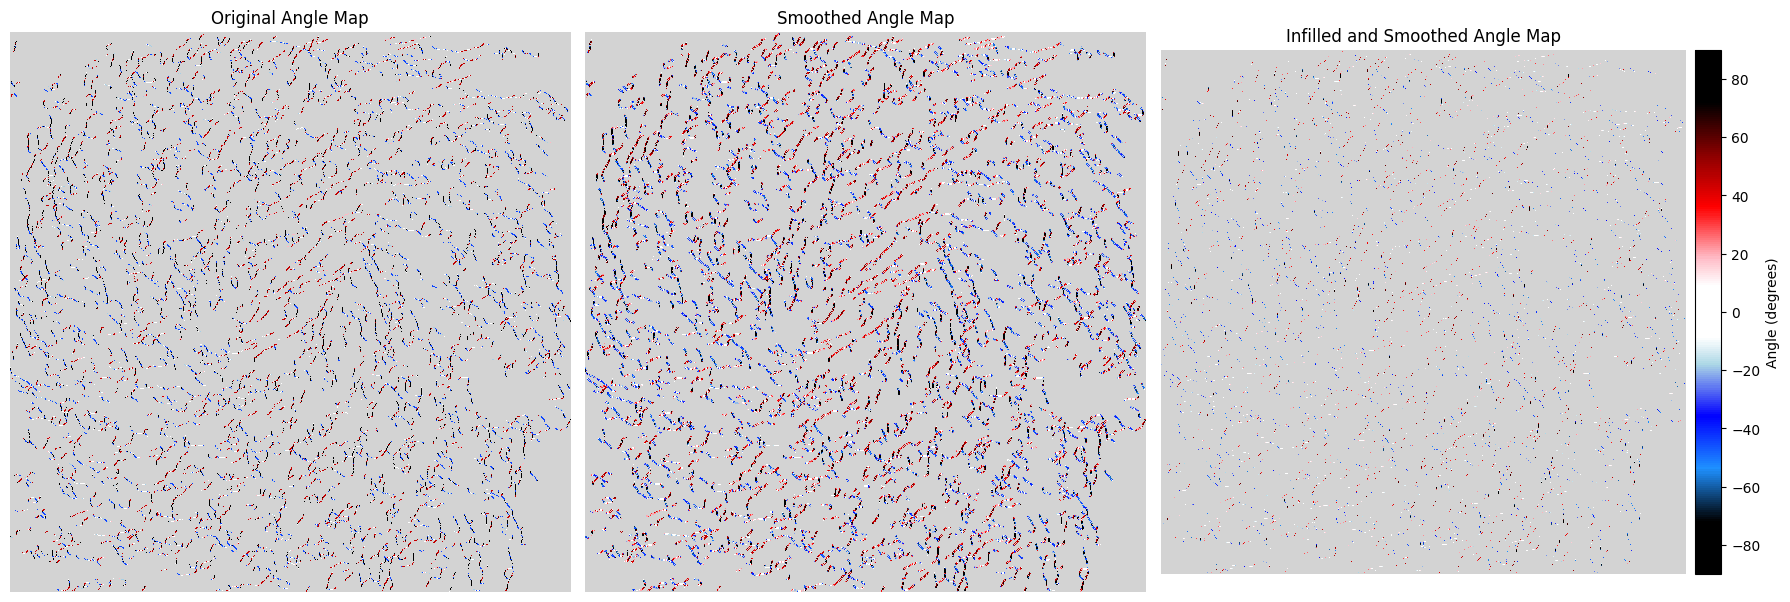

Smoothed angle map saved as C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\smoothed_angles.png


In [51]:
importlib.reload(PF)
smoothed_angles = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\smoothed_angles.png'

smoother_angle_map, smoothed_angled_map = PF.plot_arctan_with_smoothing(Gy_total, Gx_total, processed_img, 3, smoothed_angles)

c:\Users\HP\Documents\JHU_Academics\Research\PHANGS\PHANGSDustFill\Metric.py:74: RuntimeWarning: invalid value encountered in scalar divide
  order_parameter = np.sqrt(cos_sum**2 + sin_sum**2) / len(data_in_hexagon)
c:\Users\HP\Documents\JHU_Academics\Research\PHANGS\PHANGSDustFill\Metric.py:60: RuntimeWarning: invalid value encountered in scalar divide
  return 2*(total_sum/sum_weights)-1
c:\Users\HP\Documents\JHU_Academics\Research\PHANGS\PHANGSDustFill\CircularEMDTest.py:77: RuntimeWarning: invalid value encountered in scalar divide
  return (total_sum / sum_weights)


Number of hexagons: 1050
64.70047277982461 14.423151206651445
Saved FITS file: C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\Output_FITS\galaxysim_SigmaHI_CDDss0064pc_arcsinh0p1.fits_EMD_relative_Metric_hexsize40_aspectSrc2_aspectDb1_threshFact0.35_area85.33333333333333.fits
Saved FITS file: C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\Output_FITS\galaxysim_SigmaHI_CDDss0064pc_arcsinh0p1.fits_bin_metric_hexsize40_aspectSrc2_aspectDb1_threshFact0.35_area85.33333333333333.fits
Saved FITS file: C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\Output_FITS\galaxysim_SigmaHI_CDDss0064pc_arcsinh0p1.fits_bin_metric_squared_hexsize40_aspectSrc2_aspectDb1_threshFact0.35_area85.33333333333333.fits
Saved FITS file: C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\Output_FITS\galaxysim_SigmaHI_CDDss0064pc_arcsinh0p1.fits_circ_stat_metric_hexsize40_aspectSrc2_aspectDb1_threshFact0.35_area85.33333333333333.fits


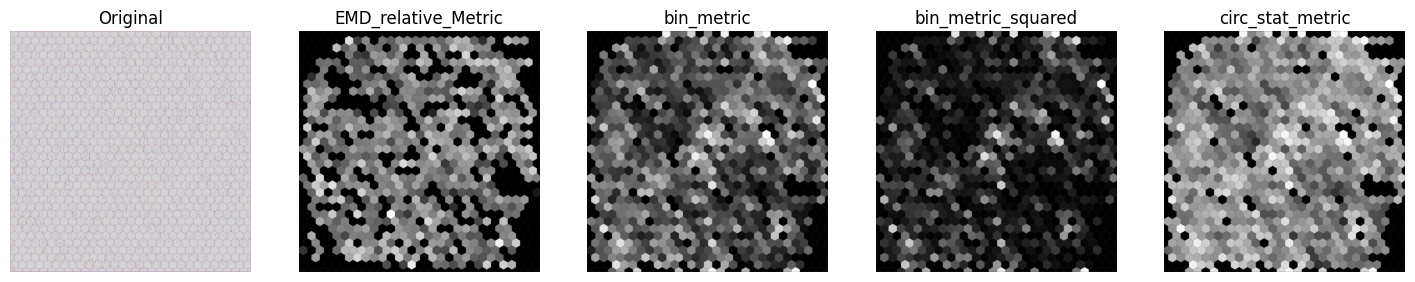

Number of hexagons: 504
52.63604783519249 19.008000835594185
Saved FITS file: C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\Output_FITS\galaxysim_SigmaHI_CDDss0064pc_arcsinh0p1.fits_EMD_relative_Metric_hexsize60_aspectSrc2_aspectDb1_threshFact0.35_area85.33333333333333.fits
Saved FITS file: C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\Output_FITS\galaxysim_SigmaHI_CDDss0064pc_arcsinh0p1.fits_bin_metric_hexsize60_aspectSrc2_aspectDb1_threshFact0.35_area85.33333333333333.fits
Saved FITS file: C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\Output_FITS\galaxysim_SigmaHI_CDDss0064pc_arcsinh0p1.fits_bin_metric_squared_hexsize60_aspectSrc2_aspectDb1_threshFact0.35_area85.33333333333333.fits
Saved FITS file: C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\Output_FITS\galaxysim_SigmaHI_CDDss0064pc_arcsinh0p1.fits_circ_stat_metric_hexsize60_aspectSrc2_aspectDb1_threshFact0.35_area85.33333333333333.fits


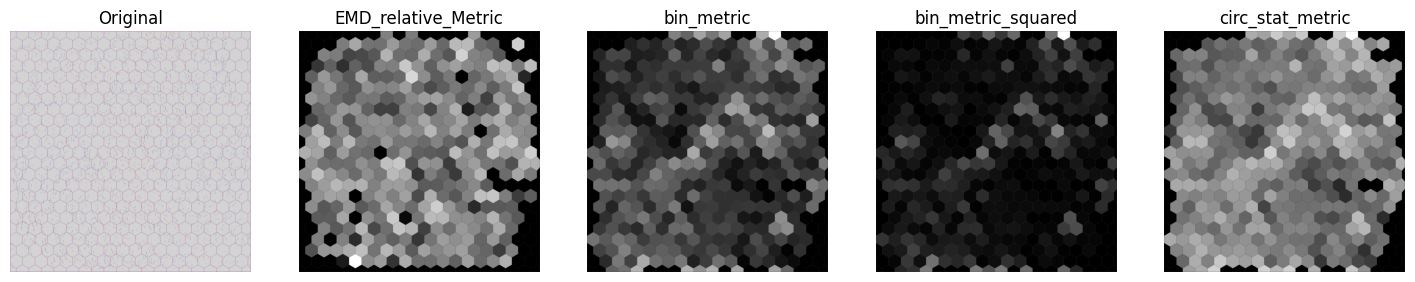

In [52]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import csv
import importlib

# Reload your GUI module if necessary
importlib.reload(myGUI)
importlib.reload(Metric)
import pandas as pd 
import RHT 
import math 
import CircularEMDTest as CT
importlib.reload(CT)

# Paths and image loading
angle_image_path = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\smoothed_angles.png'
angle_img = cv2.imread(angle_image_path, cv2.COLOR_BGR2RGB)

hex_sizes = [40,50,60]

for hexagon_size in hex_sizes: 
    # Hexagon settings
    hexagons, hexagon_image_og = myGUI.display_image_with_hexagons(angle_image_path, hexagon_size)
    hexagon_centers = [x[0] for x in hexagons]
    hexagon_corners = [x[1] for x in hexagons]
    hex_dict = {}

    # Path to the original image
    original_image_path = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\ThresholdedImage.png'
    # Load the original image in grayscale mode
    original_img = cv2.imread(original_image_path, cv2.IMREAD_GRAYSCALE)


    for i in range(len(hexagon_corners)):
        
        EMD_sum = 0
        alignment_sum = 0
        hist_metric_sum = 0

        for j in range(3):
            if j == 0:
                shift_x = 0
                shift_y = 0
            elif j ==1: 
                shift_x = -(hexagon_corners[i][5][0] - hexagon_centers[i][0])
                shift_y = -(hexagon_corners[i][5][1] - hexagon_centers[i][1])
            elif j == 2:
                shift_x = -(hexagon_corners[i][2][0] - hexagon_centers[i][0])
                shift_y = -(hexagon_corners[i][2][1] - hexagon_centers[i][1])
            # Apply shift to all corners for the current `j`
            shifted_corners = [(x + shift_x, y + shift_y) for (x, y) in hexagon_corners[i]]

            mask = myGUI.get_hexagon_mask(original_img.shape, shifted_corners)

            data_in_hexagon = smoother_angle_map[mask == 255]
            data_in_hexagon = [x for x in data_in_hexagon if not np.isnan(x)]

            segments = set(segment_map.data[mask == 255])
            segments.discard(0)  # Discard the background segment ID (0)

            # Initialize data_dict for the current hexagon
            segment_dict = {}
            for segment in segments:
                segment_mask = (segment_map.data == segment) & (mask == 255)
                # Ensure segment_mask is a boolean or integer array
                segment_mask = np.array(segment_mask, dtype=bool)

                # Collect pixel values for the segment
                segment_data = smoother_angle_map[segment_mask]
                segment_data = [x for x in segment_data if not np.isnan(x)]

                # Skip the segment if segment_data is empty
                if not segment_data:
                    continue

                intensity = np.sum(original_img[skeletonize(segment_mask)])

               # theta, R, quantiles = RHT.rht(segment_mask, radius=10, ntheta=180, background_percentile=25, verbose=False)

                segment_dict[segment] = (segment_data, intensity)

            if len(segment_dict.keys()) >= 2:
                EMD_sum += CT.compute_my_metric(segment_dict)
            else:
                EMD_sum += np.nan
            alignment_sum  += Metric.alignment_metric(data_in_hexagon)
            hist_metric_sum += Metric.compute_my_metric(data_in_hexagon)

        hex_dict[hexagon_centers[i]] = (EMD_sum/3, len(data_in_hexagon), list(segments), alignment_sum/3,hist_metric_sum/3)

    print(f'Number of hexagons: {len(hexagon_centers)}')

    # Create a new image to draw the hexagons filled with the alignment metric colors
    hexagon_image1 = Image.new("RGB", (img.shape[1], img.shape[0]))
    hexagon_image2 = Image.new("RGB", (img.shape[1], img.shape[0]))
    hexagon_image3 = Image.new("RGB", (img.shape[1], img.shape[0]))
    hexagon_image4 = Image.new("RGB", (img.shape[1], img.shape[0]))

    draw1 = ImageDraw.Draw(hexagon_image1)
    draw2 = ImageDraw.Draw(hexagon_image2)
    draw3 = ImageDraw.Draw(hexagon_image3)
    draw4 = ImageDraw.Draw(hexagon_image4)

    count = 0

    # Save hex_dict to CSV
    csv_path = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\PHANGSDustFill\thresholded_image.csv'
    with open(csv_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Hexagon Center', 'Number of Pixels', 'num_segments','EMD relative Metric', 'my hist metric', 'my hist metric sq', 'circ stat metric'])

        # Extract the first elements from each tuple
        EMD_metrics = [info[0] for info in hex_dict.values() if not np.isnan(info[0])]
        hist_metrics = [info[4] for info in hex_dict.values() if not np.isnan(info[4])]

        # Calculate the max and min values of the first elements
        EMD_max_metric = max(EMD_metrics)
        EMD_min_metric = min(EMD_metrics)
        hist_max_metric = max(hist_metrics)
        hist_min_metric = min(hist_metrics)
        print(EMD_max_metric, EMD_min_metric)
        for center, info in hex_dict.items():
            EMD_metric = info[0]
            circ_stat_metric = info[3]
            hist_metric = info[4]
            number_of_pixels = info[1]
            segments = info[2]

            EMD_relative_metric = (EMD_metric - EMD_min_metric) / (EMD_max_metric - EMD_min_metric)
            hist_relative_metric = (hist_metric - hist_min_metric) / (hist_max_metric - hist_min_metric)

            # Check if segments is an empty list or contains NaN
            if not segments or isinstance(segments, float) and np.isnan(segments):
                num_seg = 0
            else:
                num_seg = len(segments)

            writer.writerow([center, number_of_pixels, 1 - EMD_relative_metric, hist_metric, hist_metric**2, circ_stat_metric, num_seg])
            if not np.isnan(hist_metric):
                grayscale_value2 = int(255*hist_metric)
                grayscale_value3 = int(255*(hist_metric**2))  # Map to grayscale (0 to 255)
                grayscale_value4 = int(255*circ_stat_metric)
                corners = hexagon_corners[count]
                draw2.polygon(corners, fill=(grayscale_value2, grayscale_value2, grayscale_value2), outline="purple")
                draw3.polygon(corners, fill=(grayscale_value3, grayscale_value3, grayscale_value3), outline="purple")
                draw4.polygon(corners, fill=(grayscale_value4, grayscale_value4, grayscale_value4), outline="purple")
            else:
                corners = hexagon_corners[count]
                draw2.polygon(corners, fill=(0, 0, 0), outline="purple")
                draw3.polygon(corners, fill=(0, 0, 0), outline="purple")
                draw4.polygon(corners, fill=(0, 0, 0), outline="purple")
            if not np.isnan(EMD_relative_metric):
                grayscale_value1 = int(255 - EMD_relative_metric * 255)  # Map to grayscale (0 to 255)
                draw1.polygon(corners, fill=(grayscale_value1, grayscale_value1, grayscale_value1), outline="purple")
            else:
                corners = hexagon_corners[count]
                draw1.polygon(corners, fill=(0, 0, 0), outline="purple")
            count += 1

    # Convert PIL images to numpy arrays
    hexagon_image1_array = np.array(hexagon_image1.convert('L'))
    hexagon_image2_array = np.array(hexagon_image2.convert('L'))
    hexagon_image3_array = np.array(hexagon_image3.convert('L'))
    hexagon_image4_array = np.array(hexagon_image4.convert('L'))

    # Display the original and processed images with grayscale colormap
    fig, ax = plt.subplots(1, 5, figsize=(18, 18))  # Adjust the figsize as needed

    ax[0].imshow(np.flipud(hexagon_image_og))
    ax[0].set_title('Original')
    ax[0].axis('off')

    ax[1].imshow(np.flipud(hexagon_image1_array), cmap='gray')
    ax[1].set_title('EMD_relative_Metric')
    ax[1].axis('off')

    ax[2].imshow(np.flipud(hexagon_image2_array), cmap='gray')
    ax[2].set_title('bin_metric')
    ax[2].axis('off')

    ax[3].imshow(np.flipud(hexagon_image3_array), cmap='gray')
    ax[3].set_title('bin_metric_squared')
    ax[3].axis('off')

    ax[4].imshow(np.flipud(hexagon_image4_array), cmap='gray')
    ax[4].set_title('circ_stat_metric')
    ax[4].axis('off')

    # Define your hexagon images as numpy arrays
    hexagon_images = {
        'EMD_relative_Metric': hexagon_image1_array,
        'bin_metric': hexagon_image2_array,
        'bin_metric_squared': hexagon_image3_array,
        'circ_stat_metric': hexagon_image4_array
    }

    output_dir = r'C:\Users\HP\Documents\JHU_Academics\Research\PHANGS\Output_FITS'
    # Function to save an image as a FITS file
    def save_fits(image_array, filename):
        hdu = fits.PrimaryHDU(image_array)
        hdul = fits.HDUList([hdu])
        hdul.writeto(filename, overwrite=True)

    # Save each hexagon image as a FITS file with the appropriate name
    for subplot_name, image_array in hexagon_images.items():
        # Construct the filename with the sequence of variables
        filename = (f"{image_name}_{subplot_name}_hexsize{hexagon_size}_"
                    f"aspectSrc{aspect_ratio_source}_aspectDb{aspect_ratio_deblend}_"
                    f"threshFact{threshold_factor}_area{area_to_retain}.fits")
        filepath = os.path.join(output_dir, filename)
        
        # Save the FITS file
        save_fits(image_array, filepath)
        print(f"Saved FITS file: {filepath}")

    plt.show()
